
# Практична робота №3 — Класифікація твітів за тональністю (Word2Vec + scikit-learn)



In [9]:

# Блок 0 — Імпорти та перевірка оточення
import os
print("Working directory:", os.getcwd())

# Основні бібліотеки
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from gensim.models import Word2Vec
import re, string, random
from collections import Counter

# Для кращого відображення в ноутбуку
%matplotlib inline


Working directory: c:\Users\iryna.sitka\Desktop\ML\lab3


In [ ]:

# Блок 1 — Завантаження даних (шукаємо у data/)
data_paths = [
    'Corona_NLP_test.csv',
    'data/covid_tweets.csv',
    'Corona_NLP_test.csv',
    'covid_tweets.csv'
]
df = None
for p in data_paths:
    if os.path.exists(p):
        try:
            df = pd.read_csv(p, encoding='utf-8', low_memory=False)
            print(f"Loaded dataset from {p} — shape:", df.shape)
            break
        except Exception as e:
            print("Помилка при читанні", p, e)

if df is None:
    print("Датасет не знайдено. Згенеруємо маленький synthetic dataset для демонстрації.")
    data = {
        'Location': ['World']*12,
        'Tweet At': pd.date_range('2020-03-01', periods=12).astype(str),
        'Original Tweet': [
            "I am happy with the vaccine news",
            "This lockdown is terrible and depressing",
            "Totally neutral statement about weather",
            "Grateful to the healthcare workers!",
            "I hate how the economy collapsed",
            "Mixed feelings, not sure what to think",
            "Positive results from study - hope!",
            "Angry about lack of support",
            "Other commentary without sentiment",
            "I feel optimistic",
            "The situation is bad and scary",
            "Nothing to add"
        ],
        'Label': ['Positive','Negative','Other','Positive','Negative','Other','Positive','Negative','Other','Positive','Negative','Other']
    }
    df = pd.DataFrame(data)
    print("Synthetic dataset shape:", df.shape)

# Keep only required columns
if 'OriginalTweet' in df.columns and 'Sentiment' in df.columns:
    df = df[['OriginalTweet', 'Sentiment']].rename(columns={'OriginalTweet':'text','Sentiment':'label'})
else:
    raise ValueError("Відсутні потрібні колонки 'Original Tweet' або 'Sentiment' у вашому CSV.")
df.head(3)


Loaded dataset from Corona_NLP_test.csv — shape: (3798, 6)


Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [11]:

import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def preprocess(text):
    # Lowercase
    text = str(text).lower()
    # Remove URLs, mentions, hashtags (keep hashtag text), punctuation, digits
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-z\s#]', ' ', text)
    tokens = text.split()
    # Remove stopwords and short tokens
    tokens = [t.lstrip('#') for t in tokens if t not in STOPWORDS and len(t)>1]
    return tokens

# Apply preprocessing
df['tokens'] = df['text'].apply(preprocess)
df['token_len'] = df['tokens'].apply(len)
print("Token length distribution:", df['token_len'].describe())
df.head(3)


KeyError: 'text'

In [ ]:

# Блок 3 — Навчання Word2Vec (або використання pre-trained)
sentences = df['tokens'].tolist()
# Якщо sentences дуже малі — можемо додати дублікати для тренування прикладу
if len(sentences) < 50:
    sentences = sentences * 20

w2v_params = dict(vector_size=100, window=5, min_count=1, workers=1, epochs=50)
w2v = Word2Vec(sentences, **w2v_params)
print("Word2Vec vocabulary size:", len(w2v.wv.index_to_key))

def tweet_vector(tokens, model):
    # average word vectors; if token not in vocab — skip
    vecs = [model.wv[t] for t in tokens if t in model.wv.key_to_index]
    if len(vecs)==0:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

# Create embedding matrix for tweets
X_emb = np.vstack(df['tokens'].apply(lambda toks: tweet_vector(toks, w2v)).values)
y = df['label'].values
print("Embeddings shape:", X_emb.shape)


Word2Vec vocabulary size: 37
Embeddings shape: (12, 100)


In [ ]:

# Блок 4 — Розподіл на train/test
X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (9, 100) Test shape: (3, 100)


In [ ]:

# Блок 5 — Тренування моделей і оцінка для різних налаштувань PCA
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'NaiveBayes': GaussianNB()
}

pca_components = [None, 50, 100, 200]  # None означає без PCA
results = []

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

for n_comp in pca_components:
    print("\n--- PCA components:", n_comp)
    # Build pipeline
    steps = [('scaler', StandardScaler())]
    if n_comp is not None:
        steps.append(('pca', PCA(n_components=min(n_comp, X_train.shape[1]))))
    # We'll train each model separately (append classifier last)
    for mname, m in models.items():
        pipe_steps = steps + [('clf', m)]
        pipe = Pipeline(pipe_steps)
        try:
            pipe.fit(X_train, y_train_enc)
            preds = pipe.predict(X_test)
            acc = accuracy_score(y_test_enc, preds)
            crep = classification_report(y_test_enc, preds, output_dict=True, zero_division=0)
            cm = confusion_matrix(y_test_enc, preds)
            results.append({
                'model': mname, 'pca': n_comp, 'accuracy': acc, 'report': crep, 'confusion_matrix': cm
            })
            print(f"{mname}: acc={acc:.3f}")
        except Exception as e:
            print("Помилка для", mname, "з PCA", n_comp, e)



--- PCA components: None
LogisticRegression: acc=0.667
SVM: acc=0.333
RandomForest: acc=0.333
NaiveBayes: acc=0.333

--- PCA components: 50
Помилка для LogisticRegression з PCA 50 n_components=50 must be between 0 and min(n_samples, n_features)=9 with svd_solver='full'
Помилка для SVM з PCA 50 n_components=50 must be between 0 and min(n_samples, n_features)=9 with svd_solver='full'
Помилка для RandomForest з PCA 50 n_components=50 must be between 0 and min(n_samples, n_features)=9 with svd_solver='full'
Помилка для NaiveBayes з PCA 50 n_components=50 must be between 0 and min(n_samples, n_features)=9 with svd_solver='full'

--- PCA components: 100
Помилка для LogisticRegression з PCA 100 n_components=100 must be between 0 and min(n_samples, n_features)=9 with svd_solver='full'
Помилка для SVM з PCA 100 n_components=100 must be between 0 and min(n_samples, n_features)=9 with svd_solver='full'
Помилка для RandomForest з PCA 100 n_components=100 must be between 0 and min(n_samples, n_fea

,model,pca,accuracy,macro_f1
0,LogisticRegression,None,0.666667,0.555556
1,SVM,None,0.333333,0.333333
2,RandomForest,None,0.333333,0.222222
3,NaiveBayes,None,0.333333,0.166667


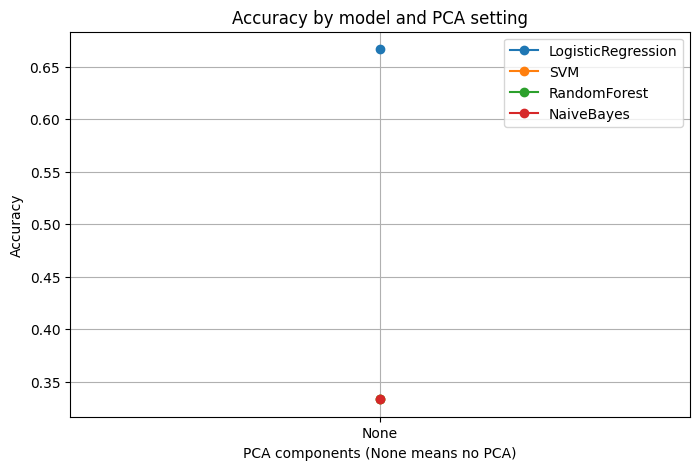

In [ ]:

# Блок 6 — Представлення результатів (подати таблицю метрик і графік впливу PCA)
import pandas as pd, seaborn as sns
# Aggregate key metrics
rows = []
for r in results:
    # macro F1 as summary
    report = r['report']
    # compute macro avg f1 if available
    macro_f1 = report.get('macro avg', {}).get('f1-score', None)
    rows.append({'model':r['model'], 'pca':str(r['pca']), 'accuracy':r['accuracy'], 'macro_f1':macro_f1})

res_df = pd.DataFrame(rows)
display(res_df)

# Plot accuracy by model and PCA
plt.figure(figsize=(8,5))
for m in res_df['model'].unique():
    subset = res_df[res_df['model']==m]
    plt.plot(subset['pca'], subset['accuracy'], marker='o', label=m)
plt.title('Accuracy by model and PCA setting')
plt.xlabel('PCA components (None means no PCA)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Best model: LogisticRegression PCA: None Accuracy: 0.6666666666666666


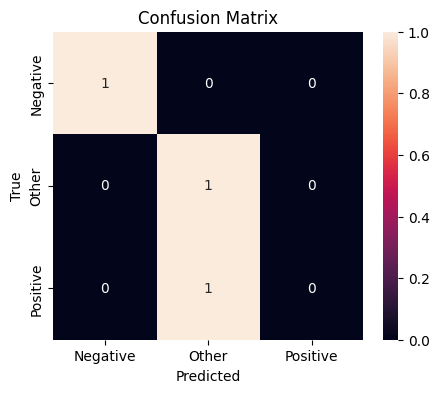

{'0': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 1.0},
 '1': {'f1-score': 0.6666666666666666,
       'precision': 0.5,
       'recall': 1.0,
       'support': 1.0},
 '2': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 1.0},
 'accuracy': 0.6666666666666666,
 'macro avg': {'f1-score': 0.5555555555555555,
               'precision': 0.5,
               'recall': 0.6666666666666666,
               'support': 3.0},
 'weighted avg': {'f1-score': 0.5555555555555555,
                  'precision': 0.5,
                  'recall': 0.6666666666666666,
                  'support': 3.0}}


In [ ]:

# Блок 7 — Confusion Matrix для найкращої моделі за accuracy
best = max(results, key=lambda x: x['accuracy'])
print("Best model:", best['model'], "PCA:", best['pca'], "Accuracy:", best['accuracy'])
cm = best['confusion_matrix']
labels = le.inverse_transform(sorted(set(y_test_enc)))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# Детальний classification report
import pprint
pprint.pprint(best['report'])
